In [1]:
from qiskit import IBMQ
# IBMQ.save_account(MY_API_TOKEN)
import qiskit
qiskit.__version__


import scipy
import numpy as np
import random

from sklearn import preprocessing
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Operator
from qiskit import(QuantumCircuit, execute, Aer)
from qiskit.visualization import plot_histogram
from qiskit.extensions import Initialize # Import the Inititialize function
from qiskit.aqua.circuits.gates import multi_control_toffoli_gate
from qiskit.aqua.circuits.gates import multi_control_multi_target_gate

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms

import timeit
import matplotlib.pyplot as plt
%matplotlib inline   
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_bool

import cv2 as cv

In [2]:
def exctract_single_qubit_measurment(dict_of_counts, qubit_range):
#     print(dict_of_counts)
#     print(len(list(dict_of_counts.keys())[0]))
    num_qubits = len(list(dict_of_counts.keys())[0])
#     result = np.zeros(len(qubit_range))
    result = np.zeros(num_qubits)
#     print(result)
    for el in dict_of_counts:
        for i in range(num_qubits):
#             print("i", i)
#             print("el[i]", el[i])
            if i in qubit_range and el[i] == '1':
                result[i] += dict_of_counts[el]
#     print(result)
#     print(result[qubit_range])
    return result[qubit_range]

In [3]:
# Wczytywanie danych inną metodą
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

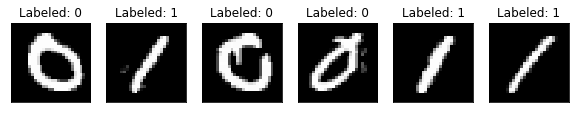

In [4]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [5]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [6]:
class QMLCircuit():
    def __init__(self, visible, hidden, num_shots=1000):
        self.visible = visible
        self.hidden = hidden
        self.ancilla = visible-1
        self.qr = QuantumRegister((self.visible + self.hidden + self.ancilla), 'q')
        self.cr = ClassicalRegister(self.hidden, 'c')
        self.qc = QuantumCircuit(self.qr, self.cr)

        self.num_shots = num_shots
    
#     def run(self, thetas):
    def circuit_function(self, x, weight_matrix):
        self.qc.data = []
#         print("x: ",x)
#         print("x[0]: ", x[0])

        # inicjalizacja wartości qubitów wejściowych (x)
        initial_state = [[np.sqrt(1-x[i]*x[i]), x[i]] for i in range(len(x))]

        # inicjalizacja wartości qubitów wejściowych i bramka Hadamarda
        for i in range(visible):
            initialize_qubit = Initialize(initial_state[i])
            self.qc.append(initialize_qubit, [i])
            self.qc.h(i)

        # ciąg bramek CNOT i bramek rotacji R (zależnych od parametrów)
        for i in range(self.hidden):
            for j in range(self.visible):
                self.qc.ry(weight_matrix[j][i], j)
#             print([self.qr[k] for k in range(self.visible)])
#             print(self.qr[self.visible + i])
#             print([self.qr[i] for i in range(self.visible + self.hidden, self.visible + self.hidden + self.ancilla)])
            multi_control_toffoli_gate.mct(self.qc, [self.qr[k] for k in range(self.visible)], self.qr[self.visible + i], [self.qr[i] for i in range(self.visible + self.hidden, self.visible + self.hidden + self.ancilla)], mode='basic')

        # pomiar linii visible
        self.qc.measure(list(range(self.visible, self.visible+self.hidden)), list(range(self.hidden)))

        #eksperyment:
        simulator = Aer.get_backend('qasm_simulator')
        job = execute(self.qc, simulator, shots=self.num_shots)
        result = job.result()
        counts = result.get_counts(self.qc)
        ph = exctract_single_qubit_measurment(counts, list(range(self.hidden))) / self.num_shots
    #     print("\nProbabilities are:",ph)
        return ph

In [12]:
visible = 2
hidden = 2
    
QMLC = QMLCircuit(visible, hidden, 1000)
#definicja wejścia (x)oraz inicjalizacja macierzy wag
x = np.array([random.uniform(0, 1) for n in range(visible)])
weight_matrix = np.random.rand(visible, hidden) * np.pi
ph = QMLC.circuit_function(x, weight_matrix)
print("ph: ", ph)
QMLC.qc.draw()

ph:  [0.003 0.03 ]


┌─────────────────────────────┐┌───┐ ┌────────────┐      ┌────────────┐»
q_0: |0>┤ Initialize(0.87976,0.47542) ├┤ H ├─┤ Ry(2.7776) ├──■───┤ Ry(2.5897) ├»
        ├─────────────────────────────┤├───┤┌┴────────────┤  │  ┌┴────────────┤»
q_1: |0>┤ Initialize(0.52219,0.85283) ├┤ H ├┤ Ry(0.14324) ├──■──┤ Ry(0.54825) ├»
        └─────────────────────────────┘└───┘└─────────────┘┌─┴─┐└─────┬─┬─────┘»
q_2: |0>───────────────────────────────────────────────────┤ X ├──────┤M├──────»
                                                           └───┘      └╥┘      »
q_3: |0>───────────────────────────────────────────────────────────────╫───────»
                                                                       ║       »
q_4: |0>───────────────────────────────────────────────────────────────╫───────»
                                                                       ║       »
 c_0: 0 ═══════════════════════════════════════════════════════════════╩═══════»
                                                                               »
 c_1: 0 ═══════════════════════════════════════════════════════════════════════»
                                                                               »
«             
«q_0: ──■─────
«       │     
«q_1: ──■─────
«       │     
«q_2: ──┼─────
«     ┌─┴─┐┌─┐
«q_3: ┤ X ├┤M├
«     └───┘└╥┘
«q_4: ──────╫─
«           ║ 
«c_0: ══════╬═
«           ║ 
«c_1: ══════╩═
«

In [13]:
# global weight_matrix
# weight_matrix = nn.Parameter(torch.tensor(np.random.rand(visible, hidden) * np.pi))
# print("self.weight_matrix: ", weight_matrix)

In [14]:
class QFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, weight_matrix, QMLC, epsilon):
        """ Forward pass computation """
        print("FORWARD BEGIN")
        ctx.epsilon = epsilon
        ctx.QMLC = QMLC
        ctx.weight_matrix = weight_matrix
        print("input from forward: ", input)
        
        print("weight_matrix: ", ctx.weight_matrix)
        
        wm = ctx.weight_matrix.tolist()
        print("wm: ", wm)
        
        ph = ctx.QMLC.circuit_function(input.tolist()[0], wm)
        
        
        result = torch.tensor([ph])
        print("result: ", result)
        ctx.save_for_backward(input, result)
        print("FORWARD END")
        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        print("BACKWARD BEGIN")
        print("grad_output: ", grad_output)
        input, ph = ctx.saved_tensors
        input_list = np.array(input.tolist())
        wm = ctx.weight_matrix.tolist()

#         print("wm: ", wm)
#         print(len(wm))
#         print(len(wm[0]))
        gradient = []
        # wyliczam część gradientu dy/dw
        for i in range(len(wm)):
            gradient_row = []
            for j in range(len(wm[0])):
                wm[i][j] += ctx.epsilon
                result_plus = ctx.QMLC.circuit_function(input_list.tolist()[0], wm)
                print(wm)

                wm[i][j] -= 2*ctx.epsilon
                result_minus = ctx.QMLC.circuit_function(input_list.tolist()[0], wm)
                print(wm)

                wm[i][j] += ctx.epsilon
                result_0 = ctx.QMLC.circuit_function(input_list.tolist()[0], wm)
                print(wm)
    #             print("exp_ph", expected_ph)
    #             print(result_plus - result_minus)
                dydw = (result_plus - result_minus)/(2*ctx.epsilon)
                djdy = (result_0 - grad_output.tolist())
                lr = 0.05
                print("dydw: ", dydw)
                print("djdy: ", djdy)
                result = djdy * dydw * lr
#                 print("result: ", result)
                gradient_row.append(np.sum(result))
            gradient.append(gradient_row)
#         print("gradient: ", gradient)
        gradient = np.array(gradient)
#         print("gradient size: ", gradient)
#         print("wm size: ", wm)
        wm -= gradient
#         print("self.weight_matrix: ", wm)
#         print(torch.tensor(gradient).float() * grad_output.float(), None, None)
#         print("BACKWARD END")
        ret = np.zeros((len(wm), 1)).T
#         print(ret)
        return torch.tensor(ret).float(), None, None, None


class QuantumLayer(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, visible, hidden, backend, shots, epsilon):
        super(QuantumLayer, self).__init__()
        self.visible = visible
        self.hidden = hidden
        self.QMLC = QMLCircuit(self.visible, self.hidden, 1000)
        self.epsilon = epsilon
#         self.weight_matrix = nn.Parameter(torch.randn(visible, hidden))
#         self.weight_matrix = np.random.rand(visible, hidden) * np.pi
        self.weight_matrix = nn.Parameter(torch.tensor(np.random.rand(visible, hidden) * np.pi))
        print("self.weight_matrix: ", self.weight_matrix)
        
    def forward(self, input):
        return QFunction.apply(input, self.weight_matrix, self.QMLC, self.epsilon)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(6400, 64)
        self.fc2 = nn.Linear(64, 2)
        self.quantum = QuantumLayer(2, 2, qiskit.Aer.get_backend('qasm_simulator'), 1000, 0.01)
        self.fc3 = nn.Linear(2, 2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 6400)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x)
#         print("softmax x: ", x)
        x = self.quantum(x)
#         print("x after quantum: ", x)
#         print("x after quantum: ", x.size())
        x = self.fc3(x.float())
#         print("x after fc3: ", x.size())
#         print("x after fc3: ", x)
        return F.log_softmax(x)
#         return x

In [16]:
# trenowanie modelu

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    print("epoch: ", epoch)
    print("weight_matrix: ", weight_matrix)
#     print("wm: ", weight_matrix)
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
#         target = target.float() # for MSELoss() function
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

self.weight_matrix:  Parameter containing:
tensor([[2.4631, 0.0576],
        [0.9005, 1.9972]], dtype=torch.float64, requires_grad=True)
epoch:  0
weight_matrix:  [[2.77764441 2.58965696]
 [0.14324223 0.54824866]]
FORWARD BEGIN
input from forward:  tensor([[0.5403, 0.4597]], grad_fn=<SoftmaxBackward>)
weight_matrix:  Parameter containing:
tensor([[2.4631, 0.0576],
        [0.9005, 1.9972]], dtype=torch.float64, requires_grad=True)
wm:  [[2.463082644583336, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
result:  tensor([[0.4830, 0.4500]], dtype=torch.float64)
FORWARD END
BACKWARD BEGIN
grad_output:  tensor([[-0.5139,  0.2661]], dtype=torch.float64)
[[2.473082644583336, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
[[2.453082644583336, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]

c:\users\mateusz\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
c:\users\mateusz\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



dydw:  [-0.8 -0.6]
djdy:  [[1.01885534 0.21290162]]
[[2.4630826445833356, 0.06763881152202797], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.047638811522027966], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [-1.6 -1.2]
djdy:  [[1.01185534 0.20290162]]
[[2.4630826445833356, 0.05763881152202797], [0.9105272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.8905272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [1.   1.05]
djdy:  [[1.02585534 0.19690162]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 2.007190953340303]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9871909533403032]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403032]]
dydw:  [-0.65 -1.3 ]
djdy:  [[1.00785534 0.21090162]]
FORWARD BEGIN
i

[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [-1.75 -0.05]
djdy:  [[1.00647121 0.22270676]]
[[2.4630826445833356, 0.06763881152202797], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.047638811522027966], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [-0.25 -0.9 ]
djdy:  [[0.99547121 0.21670676]]
[[2.4630826445833356, 0.05763881152202797], [0.9105272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.8905272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [ 1.4 -0.5]
djdy:  [[0.99647121 0.21470676]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 2.007190953340303]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9871909533403032]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1

[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [ 0.  -1.8]
djdy:  [[-0.19186284  0.8119086 ]]
[[2.4630826445833356, 0.06763881152202797], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.047638811522027966], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [-1.65  0.8 ]
djdy:  [[-0.21886284  0.8289086 ]]
[[2.4630826445833356, 0.05763881152202797], [0.9105272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.8905272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [-1.2  1.8]
djdy:  [[-0.20186284  0.8089086 ]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 2.007190953340303]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9871909533403032]]
[[2.4630826445833356, 0.05763881152202797], [0.900527258413645

[[2.4630826445833356, 0.06763881152202797], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.047638811522027966], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [-0.8  0.1]
djdy:  [[0.99423544 0.18270056]]
[[2.4630826445833356, 0.05763881152202797], [0.9105272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.8905272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [-2.1   0.45]
djdy:  [[1.00323544 0.17870056]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 2.007190953340303]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9871909533403032]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403032]]
dydw:  [ 1.55 -1.3 ]
djdy:  [[1.02923544 0.17970056]]
FORWARD BEGIN
input from forward:  tensor([[0.5373, 0.4627]], grad

[[2.453082644583336, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [ 0.8  -0.15]
djdy:  [[1.00144243 0.21281939]]
[[2.4630826445833356, 0.06763881152202797], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.047638811522027966], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [-0.1  -0.75]
djdy:  [[1.04544243 0.21481939]]
[[2.4630826445833356, 0.05763881152202797], [0.9105272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.8905272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [ 0.85 -0.05]
djdy:  [[1.00044243 0.21181939]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 2.007190953340303]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 

[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [-0.95  0.  ]
djdy:  [[1.04157626 0.22455297]]
[[2.4630826445833356, 0.06763881152202797], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.047638811522027966], [0.9005272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [ 0.8 -0.2]
djdy:  [[1.03257626 0.19855297]]
[[2.4630826445833356, 0.05763881152202797], [0.9105272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.8905272584136453, 1.9971909533403034]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9971909533403034]]
dydw:  [-0.7   0.65]
djdy:  [[1.02057626 0.19755297]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 2.007190953340303]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1.9871909533403032]]
[[2.4630826445833356, 0.05763881152202797], [0.9005272584136453, 1

KeyboardInterrupt: 

Text(0, 0.5, 'Neg Log Likelihood Loss')

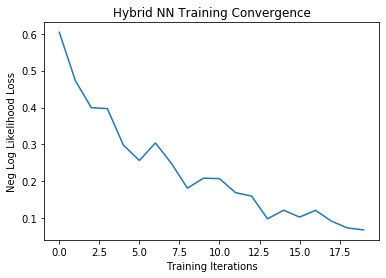

In [241]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [242]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

c:\users\mateusz\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
c:\users\mateusz\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Performance on test data:
	Loss: 0.0720
	Accuracy: 99.0%


c:\users\mateusz\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
c:\users\mateusz\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


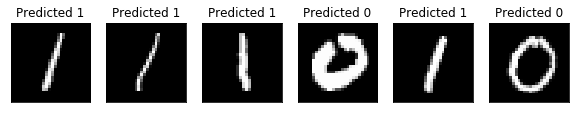

In [227]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

In [ ]:
# nie trzeba odpalać STARE FUNKCJE
epsilon = 0.01
def update(ph, expected_ph, weight_matrix, lr):
    gradient = []
    for i, row in enumerate(weight_matrix):
        gradient_row = []
        for j, el in enumerate(row):
            weight_matrix[i][j] += epsilon
            result_plus = circuit_function(qc, weight_matrix)

            weight_matrix[i][j] -= 2*epsilon
            result_minus = circuit_function(qc, weight_matrix)

            weight_matrix[i][j] += epsilon
#             result_zero = circuit_function(qc, weight_matrix)
#             print("ph", result_zero)
#             print("exp_ph", expected_ph)
#             print("el final:", el)
#             print(result_plus - result_minus)
            result = (result_plus - result_minus)/(2*epsilon) * lr * (ph - expected_ph)
            gradient_row.append(result)
        gradient.append(gradient_row)
#     print("gradient", gradient)

    weight_matrix = weight_matrix - gradient
    return weight_matrix

In [8]:
def create_dataset(dataset_size):
    dataset = []
    for i in range(dataset_size):
        x = np.array([random.choice([0,1]), random.choice([0,1])])
        y = 1
        if np.array_equal(x, np.array([0,0])) or np.array_equal(x, np.array([1,1])):
            y = 0
        dataset.append({"x": x, "y": y})
    return dataset

dataset = create_dataset(4)
print(dataset)

[{'x': array([1, 1]), 'y': 0}, {'x': array([0, 0]), 'y': 0}, {'x': array([0, 1]), 'y': 1}, {'x': array([1, 1]), 'y': 0}]


In [51]:
# template do uczenia
import matplotlib.pyplot as plt
%matplotlib inline


#definicja rozmiaru sieci
visible = 2
hidden = 1
ancilla = visible-1

#definicja wejścia (x)oraz inicjalizacja macierzy wag
# x = np.array([random.uniform(0, 1) for n in range(visible)])

dataset = create_dataset(10)
print(dataset[0]["x"][0])
print(dataset[0]["x"][1])
print([n for n in range(visible)])


weight_matrix = np.random.rand(visible, hidden) * np.pi

#definicja parametrów uczenia
num_shots = 1000
num_epochs = 100
qr = QuantumRegister(visible + hidden + ancilla, 'q')
cr = ClassicalRegister(hidden, 'c')
qc = QuantumCircuit(qr, cr)

cost_function_data = []
lr = 0.05

for epoch in range(num_epochs):
    print("epoch: ", epoch)
    for i, element in enumerate(dataset):
#         print(element)
        x = np.array([dataset[i]["x"][n] for n in range(visible)])
        exp_ph = dataset[i]["y"]
        ph = circuit_function(qc, weight_matrix)
        weight_matrix = update(ph, exp_ph, weight_matrix, lr)
#         print("exp_ph", exp_ph, "ph", ph, "weight_matrix", weight_matrix, "cost_function", 0.5 * (ph - exp_ph)**2)   
    cost_function_data.append(0.5 * (ph - exp_ph)**2)
qc.draw()
plt.xlabel('number of epochs')
plt.ylabel('cost')
plt.plot(cost_function_data)


NameError: name 'create_dataset' is not defined

In [11]:
for i in range(len(dataset)):
    x = np.array([dataset[i]["x"][n] for n in range(visible)])
    exp_ph = dataset[i]["y"]
    ph = circuit_function(qc, weight_matrix)
    print(ph)
    print(exp_ph, "\n")

0.03
0 

0.917
1 

0.045
0 

0.912
1 

0.909
1 

0.029
0 

0.053
0 

0.041
0 

0.034
0 

0.038
0 



In [12]:
qc.draw()

In [13]:
ph = circuit_function(qc, weight_matrix)
print(ph)

0.031
